In [2]:
### importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from warnings import filterwarnings 
filterwarnings('ignore')
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson as db
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import sklearn.metrics as metrics
import scipy.stats as stats
import statsmodels.stats.api as sms
from scipy.stats import zscore

In [78]:
### importing the required dataset from the excel file
df = pd.read_csv('product_data.csv')

## Dataset Understanding - Initial raw dataset

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101335 entries, 0 to 101334
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_item_id         101335 non-null  int64  
 1   price                 101335 non-null  float64
 2   freight_value         101335 non-null  float64
 3   payment_sequential    101335 non-null  int64  
 4   payment_type          101335 non-null  int64  
 5   payment_installments  101335 non-null  int64  
 6   payment_value         101335 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 5.4 MB


In [17]:
## to check the shape of data before data cleaning and feature engineering

print('Shape of data before data cleaning and feature engineering is as follows :- ')

print('Number of rows:',df.shape[0] ,'\nNumber of columns:',df.shape[1])

Shape of data before data cleaning and feature engineering is as follows :- 
Number of rows: 101335 
Number of columns: 7


In [18]:
df.describe(include='all')

,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
count,101335.000000,101335.000000,101335.000000,101335.000000,101335.000000,101335.000000,101335.000000
mean,1.205280,79.818332,16.126716,1.089495,1.352040,2.671703,124.124508
std,0.715244,56.057932,5.943237,0.689100,0.652362,2.524321,124.418064
min,1.000000,0.850000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,35.990000,12.690000,1.000000,1.000000,1.000000,55.550000
50%,1.000000,63.900000,15.470000,1.000000,1.000000,1.000000,95.400000
75%,1.000000,109.900000,18.670000,1.000000,2.000000,3.000000,155.840000
max,21.000000,270.000000,36.000000,26.000000,4.000000,24.000000,3195.730000


From the above table we infer that the minimum price of a shoe starts from 0.85, the freight value has a minimum value of 0 which means freight value is not applicable for some goods. 



In [19]:
df.isnull().sum()

order_item_id           0
price                   0
freight_value           0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

There are no null values in the given data.

In [20]:
df.head()

,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,1,58.90,13.29,1,1,2,72.19
1,1,239.90,19.93,1,1,3,259.83
2,1,199.00,17.87,1,1,5,216.87
3,1,12.99,12.79,1,1,2,25.78
4,1,199.90,18.14,1,1,3,218.04


In [ ]:
## Finding null/missing values

df.isnull().sum()

order_item_id           0
price                   0
freight_value           0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

# -------------------------------EDA---------------------------------------

In [83]:
#Removing

df=df.drop('order_item_id',axis=1)

Univariate Analysis

In [51]:
for i in df.columns:
    print(i,end=' ')
    print(df[i].nunique())

price 4188
freight_value 3267
payment_sequential 26
payment_type 4
payment_installments 24
payment_value 21231


In [52]:
df.payment_type.value_counts()


1    74164
2    20170
3     5499
4     1502
Name: payment_type, dtype: int64

Checking for outliers

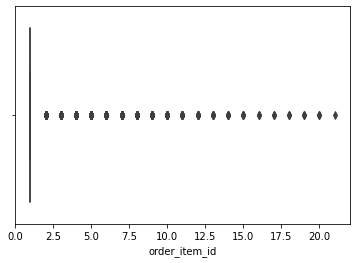

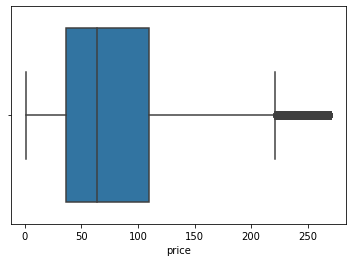

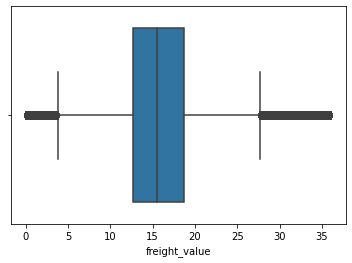

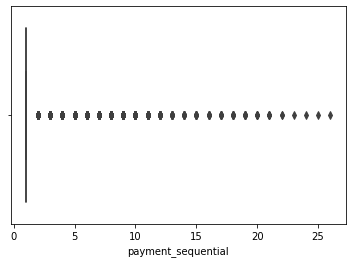

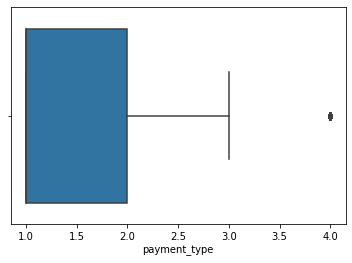

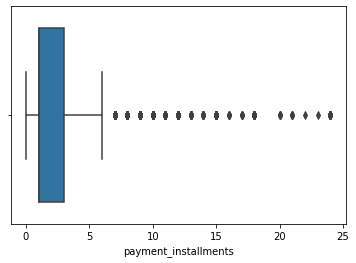

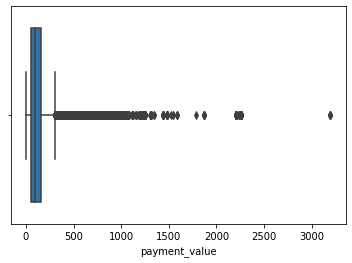

In [21]:
# Checking for outliers

for i in df.columns:
  sns.boxplot(df[i])
  plt.show()

In [57]:
df['payment_installments'].value_counts()


1     53326
2     12475
3     10340
4      6816
5      4943
10     4121
6      3577
8      3400
7      1482
9       573
12      106
15       53
11       24
18       23
24       19
13       16
14       13
16        6
17        6
20        6
21        5
0         3
23        1
22        1
Name: payment_installments, dtype: int64

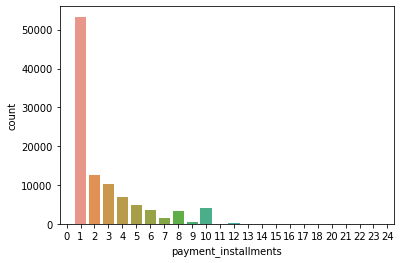

In [58]:
sns.countplot(df['payment_installments'])


In [59]:
df['payment_sequential'].value_counts()

1     97070
2      2856
3       563
4       271
5       153
6       103
7        70
8        48
9        39
10       33
11       28
12       21
13       13
14       10
15        9
16        8
17        8
18        8
19        8
20        5
21        5
22        2
25        1
23        1
24        1
26        1
Name: payment_sequential, dtype: int64

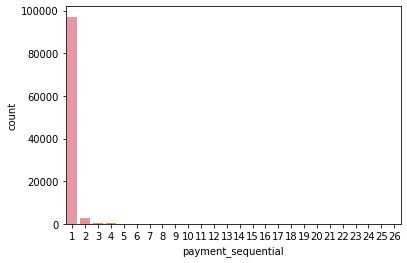

In [60]:
sns.countplot(df['payment_sequential'])


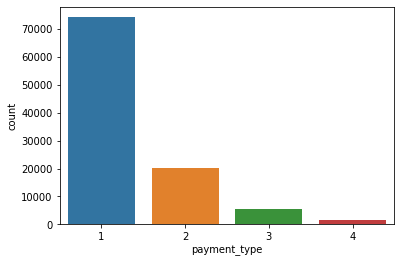

In [61]:
sns.countplot(df.payment_type)


We can observe each categorical variable having many categories

In payment installments, Out of all 24 categories 7 categories have very low count.

In payment sequential, Out of all 26 categories 12 categories have very low count

In payment type, Only the last category has less count.

BIVARIATE ANALYSIS



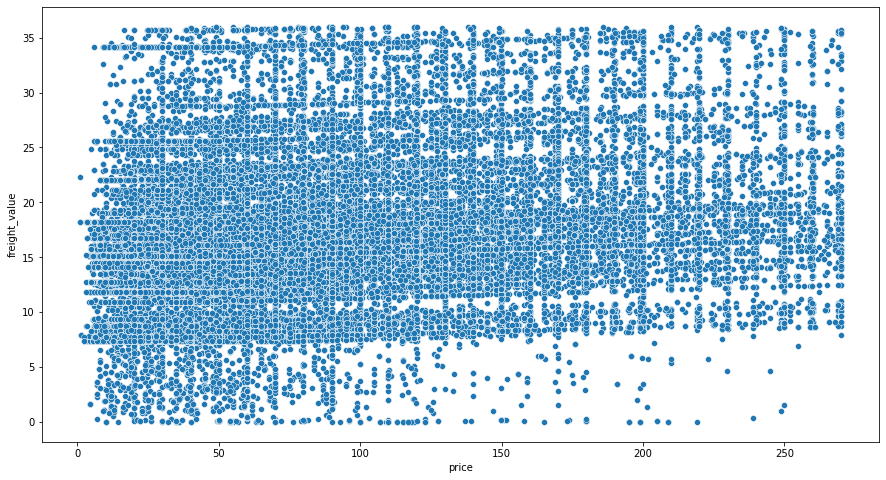

In [64]:
plt.figure(figsize=(15,8))
sns.scatterplot(df['price'],df['freight_value'])

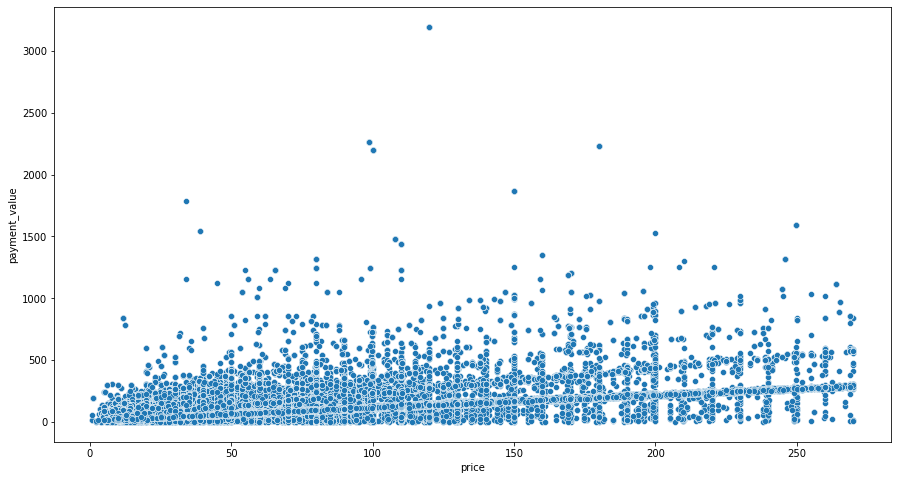

In [65]:
plt.figure(figsize=(15,8))
sns.scatterplot(df['price'],df['payment_value'])

From the plot between price and freight value that for any price there can be any freight value.That is there is no relation between freight value and price.

For the plot between price and payment_value for any price between 0-300, the payment value will be in mostly between 0 to 1000.

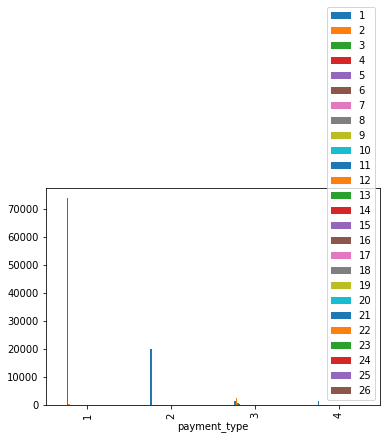

In [66]:
pd.crosstab(df['payment_type'],df['payment_sequential']).plot(kind='bar') 
plt.legend()

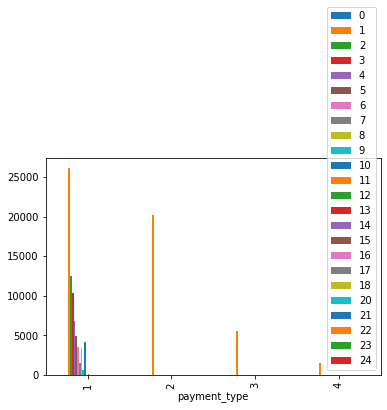

In [68]:
pd.crosstab(df['payment_type'],df['payment_installments']).plot(kind='bar') 
plt.legend()

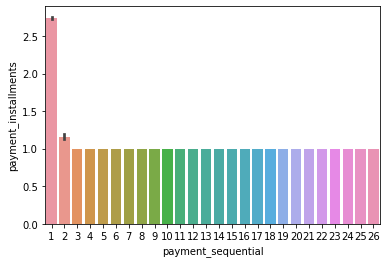

In [69]:
sns.barplot(df['payment_sequential'],df['payment_installments'])


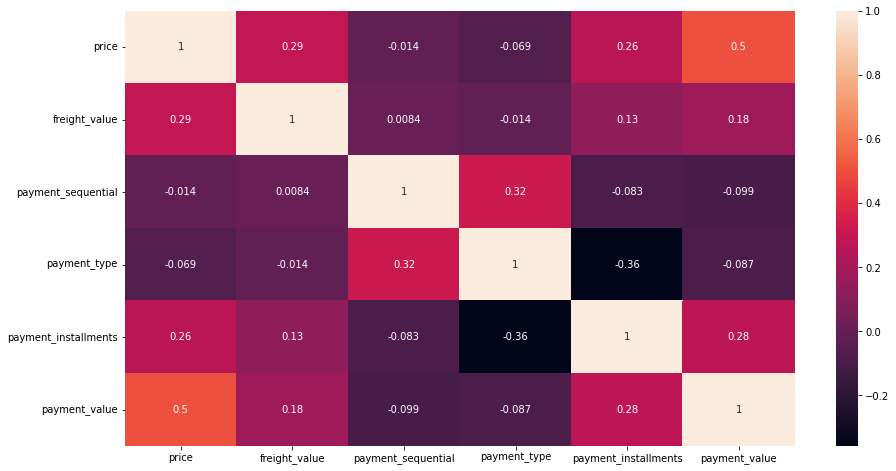

In [70]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),annot=True)
## we notice from below heatmap that there is neglible or no collinearity among the features

Data Pre-processing


In [22]:
## outlier treatment

num_cols = df[['price','payment_installments','freight_value','payment_value']]
for col in num_cols.columns:
  q1 = num_cols[col].quantile(0.25)
  q3 = num_cols[col].quantile(0.75)
  iqr = q3-q1
  ll = q1 - (1.5*iqr)
  ul = q3 + (1.5*iqr)
  for ind in df[col].index:
    if df.loc[ind,col] < ll :
      df.loc[ind,col] = ll
    elif df.loc[ind,col] > ul :
      df.loc[ind,col] = ul

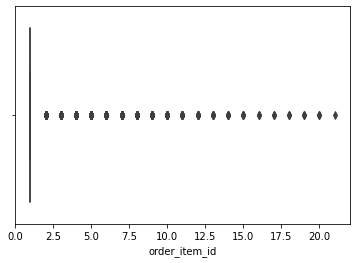

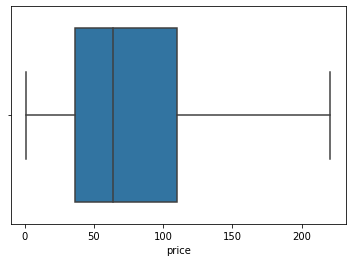

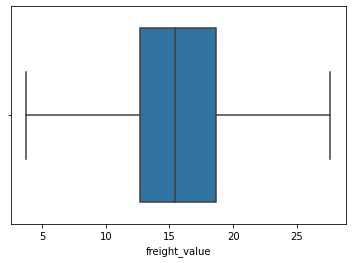

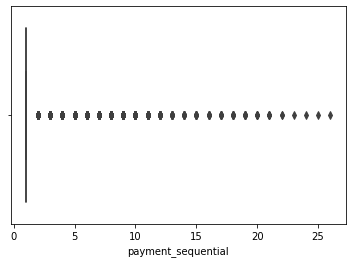

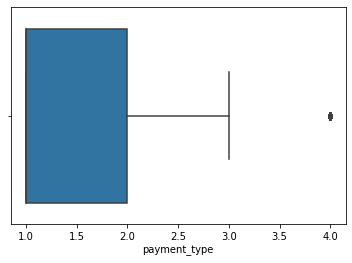

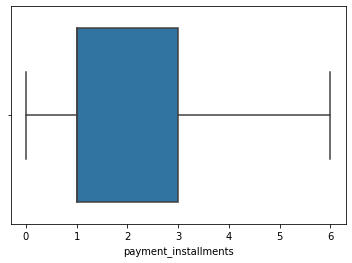

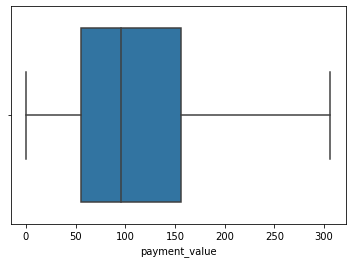

In [23]:
# Checking for outliers after outlier treatment
for i in df.columns:
  sns.boxplot(df[i])
  plt.show()

  ## from below plots we observe that the outliers are treated.

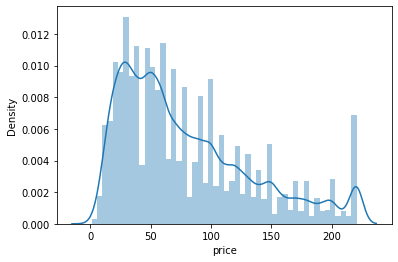

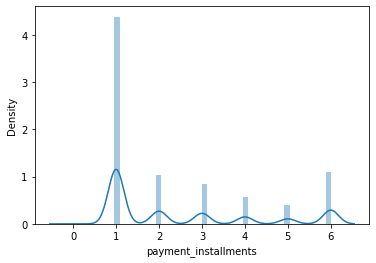

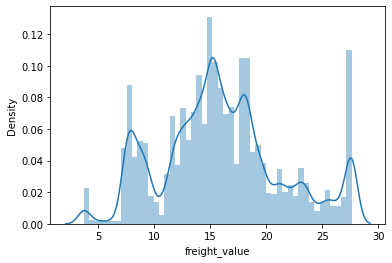

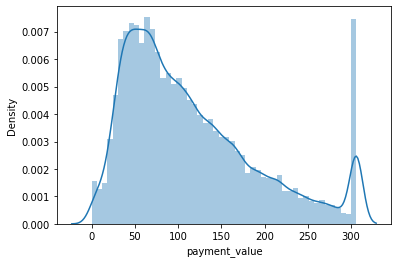

In [25]:
# Checking for skewness with distribution plot
for i in num_cols:
  sns.distplot(df[i])
  plt.show()

###### Freight has a good distribution shape but payment value is right skewed slightly


In [84]:
x=df.drop(['price'],1)
y=df['price']

In [85]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = x.columns
    vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

    return(vif)

In [86]:
calc_vif(x)

,variables,VIF
0,freight_value,5.616974
1,payment_sequential,3.728351
2,payment_type,4.867034
3,payment_installments,2.328640
4,payment_value,2.210561


Scaling

In [87]:
x=x.copy()
x[['freight_value','payment_value']]=x[['freight_value','payment_value']].apply(zscore)
x

,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,-0.477304,1,1,2,-0.417421
1,0.639938,1,1,3,1.090727
2,0.293324,1,1,5,0.745438
3,-0.561433,1,1,2,-0.790440
4,0.338754,1,1,3,0.754842
...,...,...,...,...,...
101330,3.039315,1,2,1,1.869798
101331,0.656764,1,1,3,0.126634
101332,0.138525,1,1,3,-0.058469
101333,-1.246249,1,1,3,-0.477542


#### Data Split

In [88]:
xtr,xt,ytr,yt=train_test_split(x,y,test_size=0.3,random_state=52)


In [89]:
xtr.shape,xt.shape,ytr.shape,yt.shape


((70934, 5), (30401, 5), (70934,), (30401,))

Model Building

In [91]:
import statsmodels.api as sm

xc=sm.add_constant(x)

In [92]:
basemodel=sm.OLS(y,xc).fit()
basemodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     9080.
Date:                Sun, 05 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:31:25   Log-Likelihood:            -5.3304e+05
No. Observations:              101335   AIC:                         1.066e+06
Df Residuals:                  101329   BIC:                         1.066e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   69.0316      0.461    149.638      0.000      68.127      69.936
freight_value           11.0459      0.150     73.873      0.000      10.753      11.339
payment_sequential       3.0313      0.225     13.467      0.000       2.590       3.473
payment_type             0.2723      0.253      1.077      0.282      -0.223       0.768
payment_installments     2.6634      0.065     41.141      0.000       2.537       2.790
payment_value           24.5722      0.155    158.735      0.000      24.269      24.876
==============================================================================
Omnibus:                    11314.023   Durbin-Watson:                   1.501
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            89663.650
Skew:                           0.241   Prob(JB):                         0.00
Kurtosis:                       7.583   Cond. No.                         13.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
df.price.skew()


1.0853288244552386

In [95]:
s,pval=stats.shapiro(basemodel.resid)
print(pval)
if pval>0.05:
    print('Residuals Normal')
else:
    print('Residuals Not normal')

0.0
Residuals Not normal


In [96]:
ypred=basemodel.predict(xc)

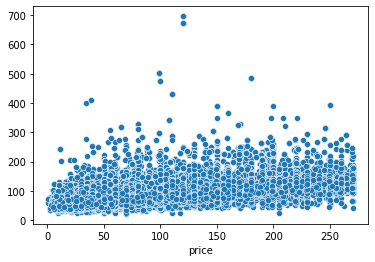

In [99]:
sns.scatterplot(y,ypred)


In [106]:
basemodel.condition_number


13.606868727131085

In [100]:
calc_vif(x)

##There is negligible or moderate multicollinearity

,variables,VIF
0,freight_value,1.039564
1,payment_sequential,3.622463
2,payment_type,3.372528
3,payment_installments,1.677855
4,payment_value,1.113105


In [101]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(basemodel.resid)


1.5010573202134356

In [105]:
import statsmodels.stats.api as sms
f,pval,s=sms.het_goldfeldquandt(basemodel.resid,xc)
if pval>=0.05:
    print('Homoscedastic')
else:
    print('Hetroscedastic')

Homoscedastic


Assumptions from above analysis are

Target is numeric 

Residuals are not Normal

The multicollinearity among the features is negligible

There is no autocorrelation as the DW value is close to 2

The model is linear.

Variance of residuals is constant(Homescedasticity)



In [107]:
ypred=basemodel.predict(xc)


In [109]:
from sklearn.metrics import mean_squared_error
rmse=np.sqrt(mean_squared_error(y,ypred))
rmse 

## Error is also high

46.58485505613209

Feature Selection

In [110]:
basemodel.pvalues[basemodel.pvalues < 0.05][1:]
## All the pvalues are less than 0.05 which indicates all the features are significant

freight_value           0.000000e+00
payment_sequential      2.663483e-41
payment_installments    0.000000e+00
payment_value           0.000000e+00
dtype: float64

In [111]:
def feature_selection(mod):
    rfe = RFE(estimator=mod)  
    rfe_model = rfe.fit(x,y)
    print(rfe_model.ranking_)

    rank= pd.DataFrame()
    rank['Feature']=x.columns
    rank['Feature_Rank']=rfe_model.ranking_

    rank=rank[rank['Feature_Rank']<=3]

    rfefea=rank['Feature'].values
    print(rfefea)

In [113]:
from sklearn.feature_selection import RFE
feature_selection(LinearRegression())


[1 2 4 3 1]
['freight_value' 'payment_sequential' 'payment_installments'
 'payment_value']


In [114]:
feature_selection(DecisionTreeRegressor())

[1 3 4 2 1]
['freight_value' 'payment_sequential' 'payment_installments'
 'payment_value']


In [115]:
feature_selection(RandomForestRegressor())


[1 3 4 2 1]
['freight_value' 'payment_sequential' 'payment_installments'
 'payment_value']


In [116]:
feature_selection(XGBRegressor())


[14:53:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:54:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:54:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[2 1 4 3 1]
['freight_value' 'payment_sequential' 'payment_installments'
 'payment_value']


We can see that features are almost similar using RFE techniques

Hence we can infer that all the features are helpful so we can proceed with all the features

In [117]:
r2_scores=[]
adj_r2_scores=[]
rmse_scores=[]
n = x.shape[0]  #no_of_rows
p = x.shape[1]  #no_of_columns 

In [118]:
def build_model(mod):
    models=mod.fit(x,y)
    k  = KFold(n_splits=5,shuffle=True, random_state=10)
    scores_rmse = cross_val_score(mod,x,y,cv=k,scoring='neg_root_mean_squared_error')
    scores_r2 = cross_val_score(mod,x,y,cv=k,scoring='r2')
    r2_scores.append(scores_r2.mean())
    adj_r2_scores.append(1-(1-(scores_r2.mean()))*(n-1)/(n-p-1))
    rmse_scores.append(np.abs(scores_rmse.mean()))
    print('Rsquared:',scores_r2.mean())
    print('Adjusted_r2:',(1-(1-(scores_r2.mean()))*(n-1)/(n-p-1)))
    print('RMSE:',np.abs(scores_rmse.mean()))

In [119]:
build_model(LinearRegression())


Rsquared: 0.3087307405821855
Adjusted_r2: 0.3086966304429648
RMSE: 46.602476673068885


In [121]:
build_model(DecisionTreeRegressor())


Rsquared: 0.7746643763212852
Adjusted_r2: 0.7746532573117381
RMSE: 26.59411301184112


In [122]:
build_model(RandomForestRegressor())


Rsquared: 0.8581626931204
Adjusted_r2: 0.8581556942697808
RMSE: 21.087292007607395


In [123]:
build_model(XGBRegressor())

[15:04:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

From the above results we see that Linear model is not working well.It may be due to the normality assumption was not satisfied

In Non - linear models, both rmse and r2 scores are comparitively good than other models.

In [125]:
rf_=RandomForestRegressor()
rf_.fit(x,y)
k  = KFold(n_splits=5,shuffle=True, random_state=10)
scores_rmse = cross_val_score(rf_,x,y,cv=k,scoring='neg_root_mean_squared_error')
scores_r2 = cross_val_score(rf_,x,y,cv=k,scoring='r2')
print(scores_r2)
print(scores_rmse)

[0.8596669  0.85421715 0.85741032 0.85514238 0.86501889]
[-21.05626279 -21.37479855 -20.98510363 -21.23032368 -20.80763584]


In [126]:
features_df = pd.DataFrame()
features_df['Importance'] = rf_.feature_importances_
features_df.index = x.columns

features_df = features_df.sort_values('Importance',ascending=False)
features_df

,Importance
payment_value,0.727244
freight_value,0.223099
payment_installments,0.026363
payment_sequential,0.014981
payment_type,0.008313


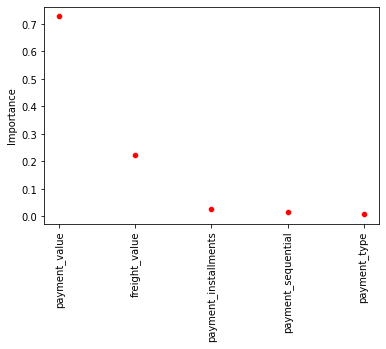

In [127]:
sns.scatterplot(x=features_df.index,y=features_df['Importance']
            ,color='red')
plt.ylabel('Importance')
plt.xticks(rotation=90);

The above plot shows the importance of features in building the model

Most Important feature for building random forest model is Payment value

In [128]:
Comparitive_Scores=pd.DataFrame({'Models':
                            ['LinearRegression','DecisionTreeRegressor'
                            ,'RandomForestRegressor','XGBRegressor'],
                                 'R2_Scores':r2_scores,'Adjusted_r2':adj_r2_scores,
                               'Root_Mean_Squared_Error':rmse_scores})

In [129]:
Comparitive_Scores=Comparitive_Scores.set_index('Models')


In [130]:
Comparitive_Scores


,R2_Scores,Adjusted_r2,Root_Mean_Squared_Error
Models,,,
LinearRegression,0.308731,0.308697,46.602477
DecisionTreeRegressor,0.774664,0.774653,26.594113
RandomForestRegressor,0.858163,0.858156,21.087292
XGBRegressor,0.629335,0.629317,34.125348


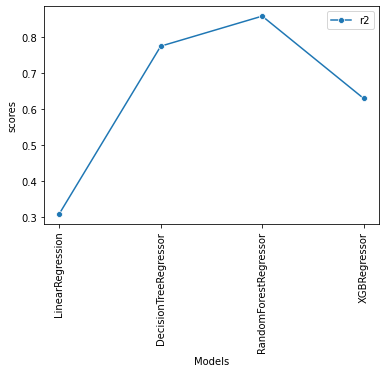

In [131]:
sns.lineplot(x=Comparitive_Scores.index,y=Comparitive_Scores['R2_Scores']
            ,marker='o',label='r2')
plt.ylabel('scores')
plt.xticks(rotation=90);

([0, 1, 2, 3], <a list of 4 Text major ticklabel objects>)

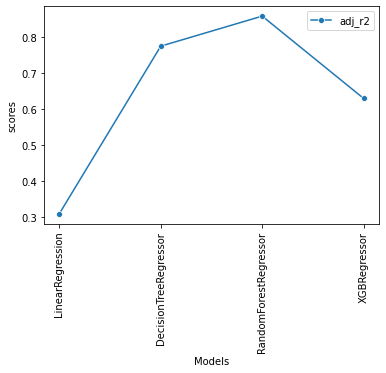

In [132]:
sns.lineplot(x=Comparitive_Scores.index,y=Comparitive_Scores['Adjusted_r2'],
            marker='o',label='adj_r2')
plt.ylabel('scores')
plt.xticks(rotation=90)

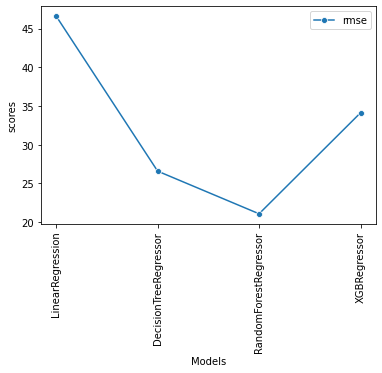

In [133]:
sns.lineplot(x=Comparitive_Scores.index,y=Comparitive_Scores['Root_Mean_Squared_Error'],
            marker='o',label='rmse')
plt.ylabel('scores')
plt.xticks(rotation=90);

We infer that Random forest regressor best explains the variation of the target feature price.

From the above plot we infer that the Random forest regressor has the least RMSE score.

Here, Random Forest Regressor has 0.8581 which can be said as this model is explaining 85.81% of variation in Target 'Price'

As we can see Adjusted r2 is similar to r2 by which we can understand that all the features are contributing in explaining the model.

Also the square root of errors are comparitively less than other non linear models

We can conclude that Random Forest is better model.